In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Fri Nov  8 14:43:47 2024


In [2]:
data = df_collector.cboe_spx_asians().iloc[:,1:]
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
filetag = f'cboe spx {pricename[:pricename.find('_',0)]}'
og_count = data.shape[0]
print(f'collected {pricename[:pricename.find('_',0)]} options')
data

collected asian options


,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price
0,4226.00000,2113.00000,7,1.00000,7,0,geometric,call,0.00066,0.01368,2021-06-08 13:08:06.854,0.81090,0.10127,-0.99995,0.53557,0.02182,2021-06-08,2112.11665
1,4226.00000,2113.00000,7,1.00000,7,0,geometric,put,0.00066,0.01368,2021-06-08 13:08:06.854,0.81090,0.10127,-0.99995,0.53557,0.02182,2021-06-08,0.00000
2,4226.00000,2113.00000,7,1.00000,7,0,arithmetic,call,0.00066,0.01368,2021-06-08 13:08:06.854,0.81090,0.10127,-0.99995,0.53557,0.02182,2021-06-08,2112.26402
3,4226.00000,2113.00000,7,1.00000,7,0,arithmetic,put,0.00066,0.01368,2021-06-08 13:08:06.854,0.81090,0.10127,-0.99995,0.53557,0.02182,2021-06-08,0.00000
4,4226.00000,3169.50000,7,1.00000,7,0,geometric,call,0.00066,0.01368,2021-06-08 13:08:06.854,0.81090,0.10127,-0.99995,0.53557,0.02182,2021-06-08,1055.63000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85315,5857.00000,7320.75000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1429.79509
85316,5857.00000,8785.00000,84,1.00000,84,0,geometric,call,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,0.00000
85317,5857.00000,8785.00000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,2887.93407
85318,5857.00000,8785.00000,84,1.00000,84,0,arithmetic,call,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,0.00000


In [3]:
pd.Series(np.random.normal(scale=0.002,size=10000)).describe()

count   10000.00000
mean        0.00003
std         0.00200
min        -0.00761
25%        -0.00134
50%         0.00001
75%         0.00137
max         0.00747
dtype: float64

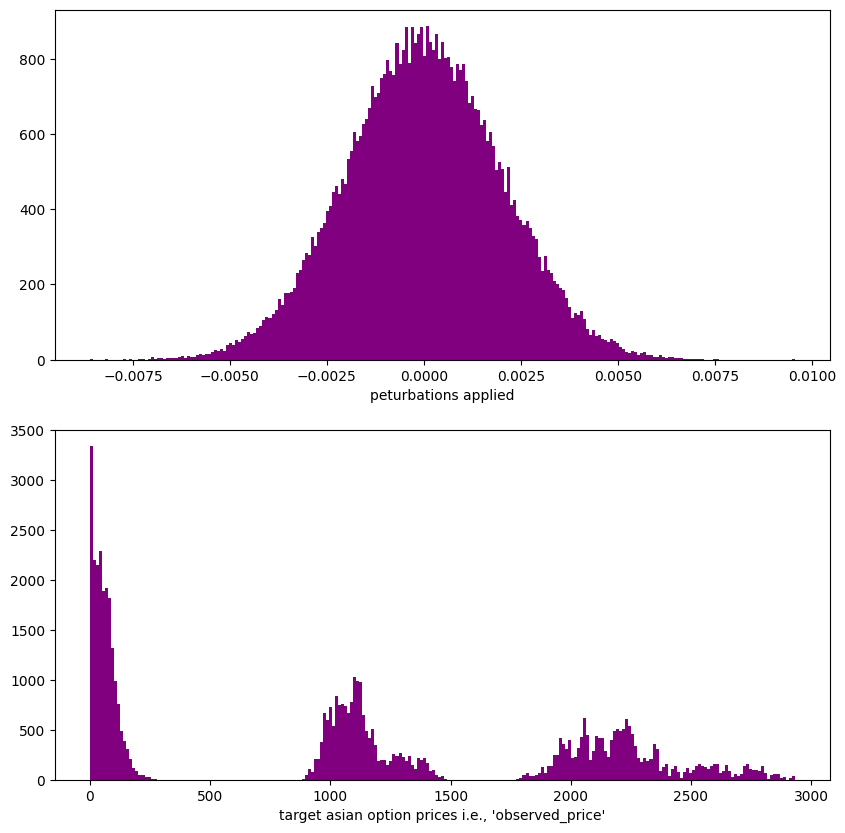

total data count: 54521
count   54521.00000
mean     1072.88686
std       912.56322
min         0.38522
25%        74.86936
50%      1074.09882
75%      2036.23991
max      2931.60008
Name: observed_price, dtype: float64


In [4]:
data = data[data[pricename]<=data['spot_price']]
data = data[data[pricename]>=0.01].copy()
data['observed_price'] = data[pricename]+np.random.normal(scale=0.002,size=data.shape[0])
data = data[data['observed_price']>=data['spot_price']*0.0001].copy()
p = data[pricename]-data['observed_price']
plotprices = data['observed_price']

fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].hist(p,bins=int(len(p)**0.5),color='purple')
axs[0].set_xlabel('peturbations applied')
axs[1].hist(plotprices,bins=int(len(plotprices)**0.5),color='purple')
axs[1].set_xlabel(f"target {pricename[:pricename.find('_')]} option prices i.e., 'observed_price'")
plt.show()
print(f"total data count: {data.shape[0]}")
print(data['observed_price'].describe())

# training procedure

In [5]:
from convsklearn import convsklearn
trainer = convsklearn()
help(trainer)
print('instance variables:')
trainer.__dict__

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object

instance variables:


{'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'observed_price',
 'excluded_features': ['barrier_price',
  'asian',
  'observed_price',
  'outin',
  'updown',
  'n_fixings'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [6]:
trainer.raw_data

""


In [7]:
trainer.load_data(data)
trainer.__dict__
trainer.dataset

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price,observed_price
0,4226.00000,2113.00000,7,1.00000,7,0,geometric,call,0.00066,0.01368,2021-06-08 13:08:06.854,0.81090,0.10127,-0.99995,0.53557,0.02182,2021-06-08,2112.11665,2112.11910
2,4226.00000,2113.00000,7,1.00000,7,0,arithmetic,call,0.00066,0.01368,2021-06-08 13:08:06.854,0.81090,0.10127,-0.99995,0.53557,0.02182,2021-06-08,2112.26402,2112.26280
4,4226.00000,3169.50000,7,1.00000,7,0,geometric,call,0.00066,0.01368,2021-06-08 13:08:06.854,0.81090,0.10127,-0.99995,0.53557,0.02182,2021-06-08,1055.63000,1055.62750
6,4226.00000,3169.50000,7,1.00000,7,0,arithmetic,call,0.00066,0.01368,2021-06-08 13:08:06.854,0.81090,0.10127,-0.99995,0.53557,0.02182,2021-06-08,1055.77737,1055.77730
8,4226.00000,4226.00000,7,1.00000,7,0,geometric,call,0.00066,0.01368,2021-06-08 13:08:06.854,0.81090,0.10127,-0.99995,0.53557,0.02182,2021-06-08,21.61087,21.61059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85311,5857.00000,5856.50000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,176.72445,176.72748
85313,5857.00000,7320.75000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1437.72795,1437.73102
85315,5857.00000,7320.75000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1429.79509,1429.79487
85317,5857.00000,8785.00000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,2887.93407,2887.93559


## preprocessing

In [8]:
dates = pd.Series(np.sort(data['date'].unique()))
dates

0      2021-06-08
1      2021-06-09
2      2021-06-10
3      2021-06-11
4      2021-06-15
          ...    
350    2024-09-24
351    2024-10-07
352    2024-10-08
353    2024-10-09
354    2024-10-14
Length: 355, dtype: object

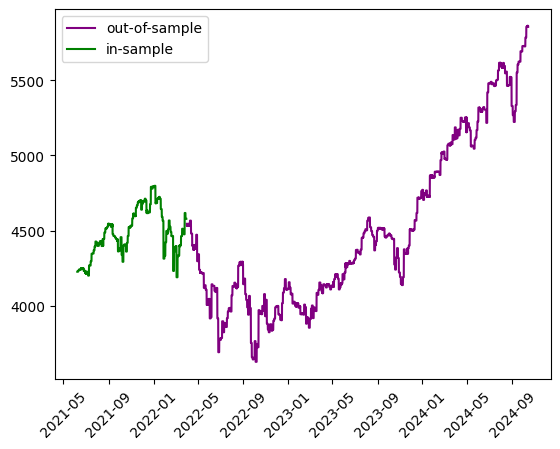

In [9]:
development_dates = dates[:len(dates)//4]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [10]:
trainer.run_dnn()


training on 14061 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 1.4040570259094238


In [11]:
print('instance varianbles:')
trainer.__dict__

instance varianbles:


{'raw_data':        spot_price  strike_price  days_to_maturity  n_fixings  \
 0      4226.00000    2113.00000                 7    1.00000   
 2      4226.00000    2113.00000                 7    1.00000   
 4      4226.00000    3169.50000                 7    1.00000   
 6      4226.00000    3169.50000                 7    1.00000   
 8      4226.00000    4226.00000                 7    1.00000   
 ...           ...           ...               ...        ...   
 85311  5857.00000    5856.50000                84    1.00000   
 85313  5857.00000    7320.75000                84    1.00000   
 85315  5857.00000    7320.75000                84    1.00000   
 85317  5857.00000    8785.00000                84    1.00000   
 85319  5857.00000    8785.00000                84    1.00000   
 
        fixing_frequency  past_fixings averaging_type     w  risk_free_rate  \
 0                     7             0      geometric  call         0.00066   
 2                     7             0     arith

In [12]:
trainer.model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'fixing_frequency',
                                                                                        'past_fixings',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'asian_price']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['averaging_type',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(15,
                                                                                       15),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())

### initial test

In [13]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 16.65988880371248
     MAE: 11.205227712483609

out of sample:
     RMSE: 88.7449299916813
     MAE: 65.96082635477258


In [14]:
oserr = trainer.test_data['outofsample_error']
iserr = trainer.train_data['insample_error']

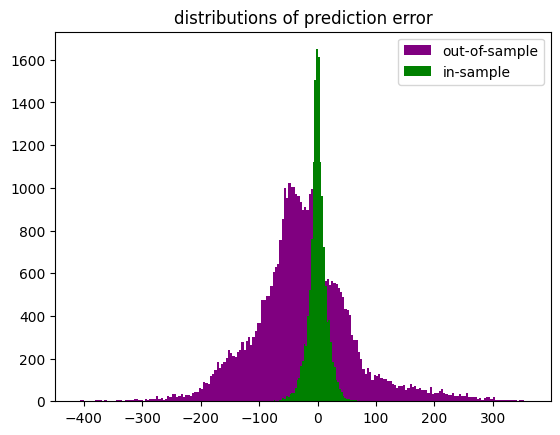

In [15]:
plt.figure()
plt.hist(oserr,color='purple',label='out-of-sample',bins=int(np.sqrt(len(oserr))))
plt.hist(iserr,color='green',label='in-sample',bins=int(np.sqrt(len(iserr))))
plt.legend()
plt.title('distributions of prediction error')
plt.show()

## saving

In [16]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_08 144351017976 cboe spx asian

cpu: 3.8792858123779297
